# Unsupervised Learning - Clustering 

Our Goal is to find the model that can incorporate new training set data without retraining the entire model. Only two clustering models in scikit-learn provide this option (the models that have partial_fit()). Thus, we can try:

* sklearn.cluster.MiniBatchKMeans
* sklearn.cluster.Birch

http://scikit-learn.org/stable/modules/scaling_strategies.html

### Table of Content
1. [features = 'b_s_1','b_s_2', 'b_s_3', 'b_s_4', 'b_s_5', 'b_s_6', 'b_s_7', 'b_s_8', 'b_s_9','b_s_10', 'b_s_11', 'b_s_12'](#bins)

     1.1 [MiniBatchKMeans Clustering Using PCA](#bins)   A good model for "Precursor."
    
     1.2 [MiniBatchKMeans Clustering Without PCA](#bins1.2)
    
     1.3 [Birch Clustering Using PCA](#bins1.3)
    
     1.4 [Birch Clustering Without PCA](#bins1.4) Does not work well.
     
2. [features2 = 'q_Imax', 'Imax_over_Imean_local', 'fluctuation_strength','low_q_ratio', 'high_q_ratio', 'Imax_over_Ilowq', 'Ilowq_over_Ihighq'](#analytical)

    2.1 [MiniBatchKMeans Clustering Using PCA](#analytical) A good model for "Bad Data" and "Structure." 
    
    2.2 [Clustering using analytical features withour PCA](#analytical2.2)
    
    2.3 [Birch Clustering With PCA](#analytical2.3)
    
    2.4 [Birch Clustering Without PCA](#analytical2.4) Does not work well.
    
    2.5 [Separating clusters by gap](#analytical2.5) It give accuracy 92% for "form_structure", but has a lot of "contra"
3. [Using Whole q Array](#q)
4. [Unsupervised Learinig Results](#results)
    


In [626]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
import random

import warnings
warnings.filterwarnings("ignore")
import pickle

from sklearn.cluster import MiniBatchKMeans #has partial_fit()
from sklearn.cluster import Birch #has partial_fit(), but the result is very similar with MiniBatchKMeans
from sklearn.cluster import DBSCAN  # works for clustering by "gap"

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.decomposition import IncrementalPCA # has partial_fit()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

I am using data from Citrination (data sets 1, 15, and 16). 

In [655]:
# this dataframe has analitic features
df = pd.read_pickle('df_for_clustering.pkl')
df.head(3)

,name,q_Imax,Imax_over_Imean,Imax_over_Imean_local,fluctuation_strength,low_q_ratio,high_q_ratio,Imax_over_Ilowq,Imax_over_Ihighq,Ilowq_over_Ihighq,...,b_s_11,b_s_12,b_s_13,b_s_14,b_s_15,b_s_16,b_s_17,b_s_18,b_s_19,b_s_20
0,set_1_R1_1479582658,0.489,1.343762,1.302965,14.996414,0.633562,0.366438,1.725431,1.309675,0.759042,...,-0.293660,-0.332603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,set_1_R1_1479582669,0.275,1.234448,1.133807,17.833578,0.634872,0.365128,1.609803,1.207450,0.750061,...,-0.200915,-0.247893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,set_1_R1_1479582681,0.103,1.265933,1.338246,17.744758,0.636601,0.363399,1.630249,1.244138,0.763158,...,-0.218888,-0.291770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [656]:
df.shape

(2170, 30)

In [657]:
df.columns

Index(['name', 'q_Imax', 'Imax_over_Imean', 'Imax_over_Imean_local',
       'fluctuation_strength', 'low_q_ratio', 'high_q_ratio',
       'Imax_over_Ilowq', 'Imax_over_Ihighq', 'Ilowq_over_Ihighq', 'b_s_1',
       'b_s_2', 'b_s_3', 'b_s_4', 'b_s_5', 'b_s_6', 'b_s_7', 'b_s_8', 'b_s_9',
       'b_s_10', 'b_s_11', 'b_s_12', 'b_s_13', 'b_s_14', 'b_s_15', 'b_s_16',
       'b_s_17', 'b_s_18', 'b_s_19', 'b_s_20'],
      dtype='object')

In [658]:
features = ['b_s_1',
       'b_s_2', 'b_s_3', 'b_s_4', 'b_s_5', 'b_s_6', 'b_s_7', 'b_s_8', 'b_s_9',
       'b_s_10', 'b_s_11', 'b_s_12'] # since q usially is in range 0 - 0.6, we have only zeros in "b_s_13" - "b_s_20"

features2 = ['q_Imax', 'Imax_over_Imean_local', 'fluctuation_strength',
       'low_q_ratio', 'high_q_ratio', 'Imax_over_Ilowq', 'Ilowq_over_Ihighq']

In [659]:
# Scaler demo
scaler = preprocessing.StandardScaler()
data = [[0, 0], [0, 0], [1, 1], [1, 1]]
scaler.fit(data)
print("mean: ", scaler.mean_)
print("transformed data: ", scaler.transform(data))
print('transformed [2,2]: ', scaler.transform([[2, 2]]))

mean:  [ 0.5  0.5]
transformed data:  [[-1. -1.]
 [-1. -1.]
 [ 1.  1.]
 [ 1.  1.]]
transformed [2,2]:  [[ 3.  3.]]


In [660]:
def doPCA(data, num_of_componets):
    pca = IncrementalPCA(n_components=num_of_componets)
    pca.fit(data)
    return pca

<a id=bins></a>

# features = ['b_s_1','b_s_2', 'b_s_3', 'b_s_4', 'b_s_5', 'b_s_6', 'b_s_7', 'b_s_8', 'b_s_9','b_s_10', 'b_s_11', 'b_s_12']

## 1.1 MiniBatchKMeans Clustering Using PCA

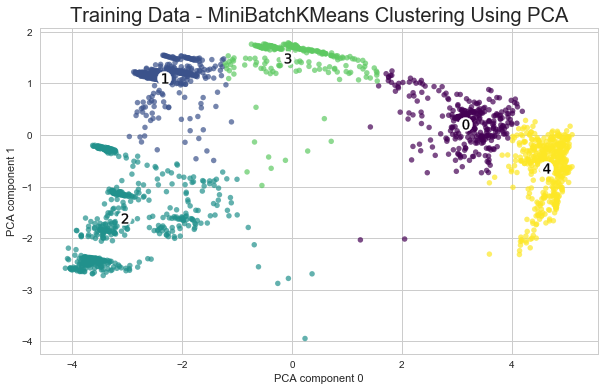

In [662]:
sns.set_style('whitegrid')

scaler = preprocessing.StandardScaler()
scaler.fit(df[features])
pca = doPCA(scaler.transform(df[features]), 2)
transformed_data = pca.transform(scaler.transform(df[features]))

clusterer4_pca = MiniBatchKMeans(n_clusters=5, random_state=10)
#clusterer4_pca = Birch(n_clusters=5)
cluster_labels4_pca = clusterer4_pca.fit_predict(transformed_data)
#cluster_labels4_pca = clusterer4_pca.fit_predict(scaler.transform(df[features]))

fig, axes = plt.subplots(figsize=(10,6))
plt.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels4_pca, cmap= 'viridis')

centers = clusterer4_pca.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=100, c='black')
plt.title('Training Data - MiniBatchKMeans Clustering Using PCA', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

### To check the result using our validation set

#### Labels of Validatadion Dataset using the same PCA:

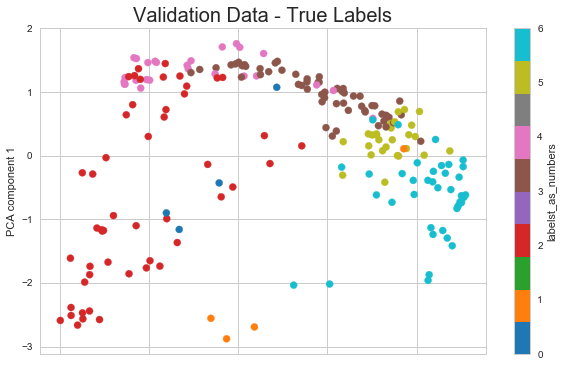

In [663]:
df_val = pd.read_csv('validation_set_20.csv')
transformed_data_val = pca.transform(scaler.transform(df_val[features]))

labels_dict = {'form_precursor_structure': 0, 'precursor_structure': 1, 'form_structure': 2, 
               'form_precursor_': 3, 'form_': 4, 'precursor_': 5, 'bad_data': 6}
labelst_as_numbers = []
for i in df_val['srt_label_tr']:
    labelst_as_numbers.append(labels_dict[i])
    
df_val['pc0'] = transformed_data_val[ : ,0]
df_val['pc1'] = transformed_data_val[ : ,1]
df_val['labelst_as_numbers'] = labelst_as_numbers
    
df_val.plot.scatter(x='pc0',y='pc1',c='labelst_as_numbers',cmap='tab10',s= 50, figsize=(10,6))

plt.title('Validation Data - True Labels', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

**Colors correspond to "true" labels:**
* 6 - light blue - bad data
* 5 - dark yellow - precursor
* 4 - pink - form
* 3 - broun - form_precursor
* 2 - red - form_structure
* 1 - orange - precursor_structure
* 0 - blue - form_precursor_structure

**The distribution of labels are related with clasters. **

Let's separate our validataion dataset into clusters using our clustering model and see what kind of labels we have in every cluster.

In [664]:
# validation set is not form Citrination
df_val = pd.read_csv('validation_set_20.csv')
transformed_data_val = pca.transform(scaler.transform(df_val[features]))

cluster_labels_val = clusterer4_pca.predict(transformed_data_val)
df_val['5_cl_using_features'] = cluster_labels_val 

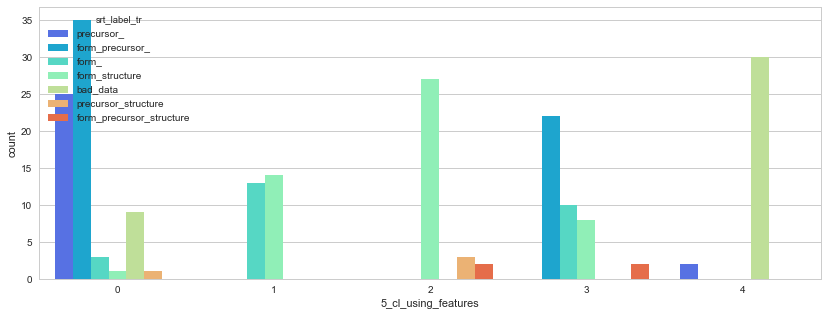

In [665]:
fig, axes = plt.subplots(figsize=(14,5))
sns.countplot(data=df_val, hue='srt_label_tr',x = '5_cl_using_features',palette='rainbow')

This clastering makes some sence:
* cluster 4: bad_data
* almost all precursor is in clusters 0 and 3
* all samples in clustet 2 has structure

Let's try create the labels for our validation set based on clustering

In [666]:
df_val.loc[(df_val["5_cl_using_features"]== 4) , "bad_data"] = 1
df_val.loc[df_val["bad_data"]!= 1, "bad_data"] = 0
accuracy_score(df_val['bad_data_tr'], df_val['bad_data'])

0.9468599033816425

In [667]:
df_val.loc[(df_val["5_cl_using_features"]== 0) | (df_val["5_cl_using_features"]== 3), "precursor"] = 1
df_val.loc[df_val["precursor"]!= 1, "precursor"] = 0
accuracy_score(df_val['precursor_tr'], df_val['precursor'])

0.81642512077294682

In [668]:
df_val.loc[(df_val["5_cl_using_features"]== 2), "structure"] = 1
df_val.loc[df_val["structure"]!= 1, "structure"] = 0
accuracy_score(df_val['structure_tr'], df_val['structure'])

0.87439613526570048

**Problem:** we need to separate precursor and form_precursor

In [670]:
# By the end I realized that this model is the best from unsupervied models for Precursor.
# Thus, I decided to save it and use for "precursor" labels.


# to sava the scaler:
pickle.dump(scaler, open('models_scalers_pca/scaler_for_5_clusterers_bin_str_pca2_Precursor_in_0_5.pkl', 'wb'))

# to save the PCA:
pickle.dump(pca, open('models_scalers_pca/pca_for_5_clusterers_bin_str_pca2_Precursor_in_0_5.pkl', 'wb'))

# to save the model:
pickle.dump(clusterer4_pca, open('models_scalers_pca/model_for_5_clusterers_bin_str_pca2_Precursor_in_0_5.pkl', 'wb'))
 
# some time later...
 
#loaded_model = pickle.load(open('models_scalers_pca/5_clusterers_bin_str_pca2_Precursor_in_0_5.pkl', 'rb'))
#cluster_labels_val = loaded_model.predict(transformed_data_val)

<a id=bins1.2></a>

## 1.2 MiniBatchKMeans Clustering Without PCA

Here I am using PCA for vizualizaton only.

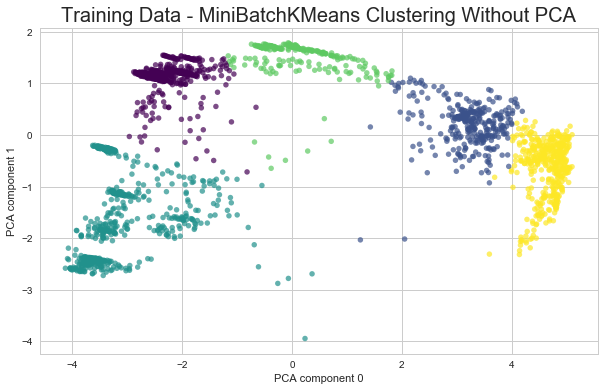

In [557]:
scaler = preprocessing.StandardScaler()
scaler.fit(df[features])
pca = doPCA(scaler.transform(df[features]), 2)
transformed_data = pca.transform(scaler.transform(df[features]))

clusterer4_pca = MiniBatchKMeans(n_clusters=5)
# we fit the model using scaled data wihtout PCA transformation
cluster_labels4_pca = clusterer4_pca.fit_predict(scaler.transform(df[features]))

fig, axes = plt.subplots(figsize=(10,6))
plt.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels4_pca, cmap= 'viridis')

plt.title('Training Data - MiniBatchKMeans Clustering Without PCA', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

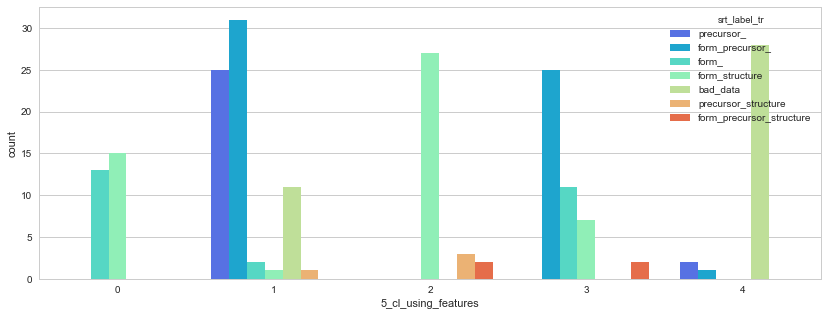

In [558]:
df_val = pd.read_csv('validation_set_20.csv')
transformed_data_val = pca.transform(scaler.transform(df_val[features]))

cluster_labels_val = clusterer4_pca.predict(scaler.transform(df_val[features]))
df_val['5_cl_using_features'] = cluster_labels_val 

fig, axes = plt.subplots(figsize=(14,5))
sns.countplot(data=df_val, hue='srt_label_tr',x = '5_cl_using_features',palette='rainbow')

In [501]:
df_val.loc[(df_val["5_cl_using_features"]== 4) , "bad_data"] = 1
df_val.loc[df_val["bad_data"]!= 1, "bad_data"] = 0
accuracy_score(df_val['bad_data_tr'], df_val['bad_data'])

0.93236714975845414

In [502]:
df_val.loc[(df_val["5_cl_using_features"]== 0) | (df_val["5_cl_using_features"]== 3), "precursor"] = 1
df_val.loc[df_val["precursor"]!= 1, "precursor"] = 0
accuracy_score(df_val['precursor_tr'], df_val['precursor'])

0.80676328502415462

In [503]:
df_val.loc[(df_val["5_cl_using_features"]== 1), "structure"] = 1
df_val.loc[df_val["structure"]!= 1, "structure"] = 0
accuracy_score(df_val['structure_tr'], df_val['structure'])

0.87439613526570048

The result is almost the same as when we fit cluster PCA data.

<a id = bins1.3></a>

## 1.3 Birch Clustering Using PCA

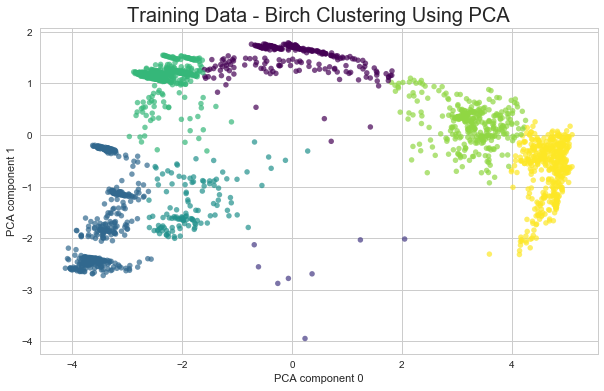

In [565]:
sns.set_style('whitegrid')

scaler = preprocessing.StandardScaler()
scaler.fit(df[features])
pca = doPCA(scaler.transform(df[features]), 2)
transformed_data = pca.transform(scaler.transform(df[features]))

clusterer4_pca = Birch(n_clusters=7)
cluster_labels4_pca = clusterer4_pca.fit_predict(transformed_data)
#cluster_labels4_pca = clusterer4_pca.fit_predict(scaler.transform(df[features]))

classes = [0,1,2,3,4,5,6]

fig, axes = plt.subplots(figsize=(10,6))
plt.scatter(transformed_data[ : ,0],transformed_data[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels4_pca,
            cmap= 'viridis')

plt.title('Training Data - Birch Clustering Using PCA', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

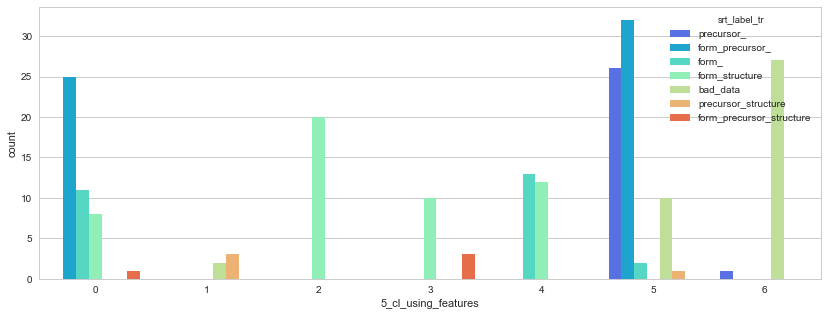

In [567]:
df_val = pd.read_csv('validation_set_20.csv')
transformed_data_val = pca.transform(scaler.transform(df_val[features]))

cluster_labels_val = clusterer4_pca.predict(transformed_data_val)
df_val['5_cl_using_features'] = cluster_labels_val 

fig, axes = plt.subplots(figsize=(14,5))
sns.countplot(data=df_val, hue='srt_label_tr',x = '5_cl_using_features',palette='rainbow')

In [569]:
df_val.loc[(df_val["5_cl_using_features"]== 6), "bad_data"] = 1
df_val.loc[df_val["bad_data"]!= 1, "bad_data"] = 0
accuracy_score(df_val['bad_data_tr'], df_val['bad_data'])

0.9371980676328503

In [570]:
df_val.loc[(df_val["5_cl_using_features"]== 0) | (df_val["5_cl_using_features"]== 5), "precursor"] = 1
df_val.loc[df_val["precursor"]!= 1, "precursor"] = 0
accuracy_score(df_val['precursor_tr'], df_val['precursor'])

0.81642512077294682

In [571]:
df_val.loc[(df_val["5_cl_using_features"]!= 6) , "form"] = 1
df_val.loc[df_val["form"]!= 1, "form"] = 0
accuracy_score(df_val['form_tr'], df_val['form'])

0.79710144927536231

In [573]:
df_val.loc[(df_val["5_cl_using_features"]== 1) | (df_val["5_cl_using_features"]== 2)  | 
           (df_val["5_cl_using_features"]== 3), "srtucture"] = 1
df_val.loc[df_val["srtucture"]!= 1, "srtucture"] = 0
accuracy_score(df_val['structure_tr'], df_val['srtucture'])

0.88405797101449279

<a id = bins1.4></a>

## 1.4 Birch Clustering Without PCA

Birch withour PCA works not very well for us - it does not separate Bad Data and Precursor.

<a id = analytical> </a>

# features2 = ['q_Imax', 'Imax_over_Imean_local', 'fluctuation_strength','low_q_ratio', 'high_q_ratio', 'Imax_over_Ilowq', 'Ilowq_over_Ihighq']

## 2.1 MiniBatchKMeans Clustering Using PCA

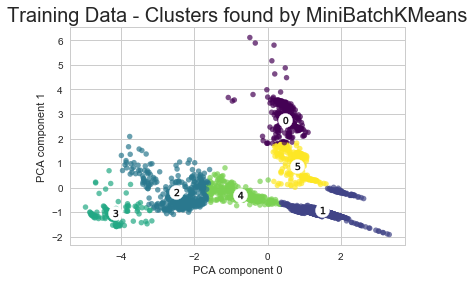

In [671]:
sns.set_style('whitegrid')

scaler = preprocessing.StandardScaler()
scaler.fit(df[features2])
pca = doPCA(scaler.transform(df[features2]), 2)
transformed_data = pca.transform(scaler.transform(df[features2]))
ind = np.argmax(transformed_data[ : ,1]) # outlier
transformed_data2 = np.delete(transformed_data, ind, 0) # to remove the ourlier

clusterer_pca = MiniBatchKMeans(n_clusters=6, random_state=10, n_init= 20)
cluster_labels2_pca = clusterer_pca.fit_predict(transformed_data2)

plt.scatter(transformed_data2[ : ,0],transformed_data2[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels2_pca, cmap= 'viridis')

centers = clusterer_pca.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, color='black')
plt.title('Training Data - Clusters found by MiniBatchKMeans', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

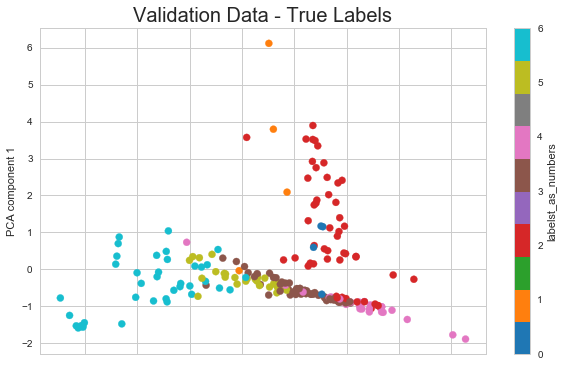

In [643]:
df_val = pd.read_csv('validation_set_20.csv')
transformed_data_val = pca.transform(scaler.transform(df_val[features2]))

labels_dict = {'form_precursor_structure': 0, 'precursor_structure': 1, 'form_structure': 2, 
               'form_precursor_': 3, 'form_': 4, 'precursor_': 5, 'bad_data': 6}
labelst_as_numbers = []
for i in df_val['srt_label_tr']:
    labelst_as_numbers.append(labels_dict[i])
    
df_val['pc0'] = transformed_data_val[ : ,0]
df_val['pc1'] = transformed_data_val[ : ,1]
df_val['labelst_as_numbers'] = labelst_as_numbers
    
df_val.plot.scatter(x='pc0',y='pc1',c='labelst_as_numbers',cmap='tab10',s= 50, figsize=(10,6))
plt.title('Validation Data - True Labels', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

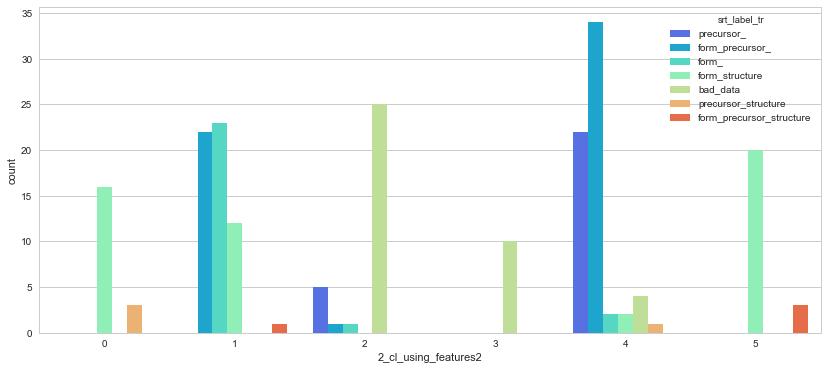

In [644]:
df_val = pd.read_csv('validation_set_20.csv')
transformed_data_val = pca.transform(scaler.transform(df_val[features2]))
cluster_labels_val = clusterer_pca.predict(transformed_data_val)
df_val['2_cl_using_features2'] = cluster_labels_val 

fig, axes = plt.subplots(figsize=(14,6))
sns.countplot(data=df_val, hue='srt_label_tr',x = '2_cl_using_features2',palette='rainbow')

We got:
* almost all bad_data in the clusters 3 and 2
* a lot of precursor and form_precursor in the cluster 4
* almost all samples in clusters 0, 1, 5 and 4 have form
* all samples in clusters 0 and 5 have structure

Let's make **"bad_data"** label for samples in clusters 2 and 3:

In [645]:
df_val.loc[(df_val["2_cl_using_features2"]== 2) | (df_val["2_cl_using_features2"]== 3), "bad_data"] = 1
df_val.loc[df_val["bad_data"]!= 1, "bad_data"] = 0

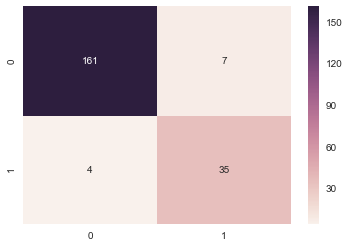

In [646]:
cnf_matrix = confusion_matrix(df_val['bad_data_tr'], df_val['bad_data'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

In [647]:
accuracy_score(df_val['bad_data_tr'], df_val['bad_data'])

0.9468599033816425

**we got accuracy 94.6% for bad data**


Label for **"precursor"**:

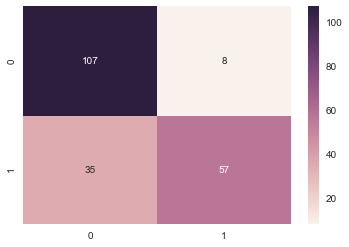

In [648]:
df_val.loc[(df_val["2_cl_using_features2"]== 4) , "precursor"] = 1
df_val.loc[df_val["precursor"]!= 1, "precursor"] = 0

cnf_matrix = confusion_matrix(df_val['precursor_tr'], df_val['precursor'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

In [649]:
accuracy_score(df_val['precursor_tr'], df_val['precursor']) # very good for precursor!

0.79227053140096615

Label for **form**:

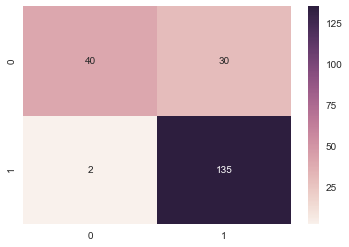

In [650]:
df_val.loc[(df_val["2_cl_using_features2"]== 1) | (df_val["2_cl_using_features2"]== 5) | 
           (df_val["2_cl_using_features2"]== 4) | (df_val["2_cl_using_features2"]== 0), "form"] = 1
df_val.loc[df_val["form"]!= 1, "form"] = 0

cnf_matrix = confusion_matrix(df_val['form_tr'], df_val['form'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

In [651]:
accuracy_score(df_val['form_tr'], df_val['form']) # we had a better result (94%) with supervised learning

0.84541062801932365

It is possible that we have very few samples in our data set that have "form": true, but "structure" and 'precursor': false

Label for **structure**:

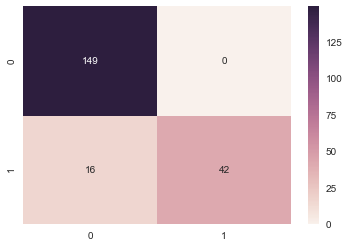

In [652]:
df_val.loc[(df_val["2_cl_using_features2"]== 0)  | (df_val["2_cl_using_features2"]== 5) , "structure"] = 1
df_val.loc[df_val["structure"]!= 1, "structure"] = 0

cnf_matrix = confusion_matrix(df_val['structure_tr'], df_val['structure'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g')

In [653]:
accuracy_score(df_val['structure_tr'], df_val['structure']) # good!

0.92270531400966183

In [654]:
# to sava the scaler:
pickle.dump(scaler, open('models_scalers_pca/scaler_for_6_clusterers_analytical_pca2_baddata_2_3_form_0_1_4_5_structure_0_5.pkl', 'wb'))

# to save the PCA:
pickle.dump(pca, open('models_scalers_pca/pca_for_6_clusterers_analytical_pca2_baddata_2_3_form_0_1_4_5_structure_0_5.pkl', 'wb'))

# to save the model:
pickle.dump(clusterer_pca, open(''models_scalers_pca/clusterer6_analytica_pca2_baddata_2_3_form_0_1_4_5_structure_0_5.pkl', 'wb'))
 
# some time later...
 
#loaded_model = pickle.load(open(''models_scalers_pca/clusterer6_analytica_pca2_baddata_2_3_form_0_1_4_5_structure_0_5.pkl', 'rb'))
#cluster_labels_val = loaded_model.predict(transformed_data_val)

<a id = analytical2.2> </a>

## 2.2 Clustering using analytical features withour PCA

Here I am using PCA for vizualization only.

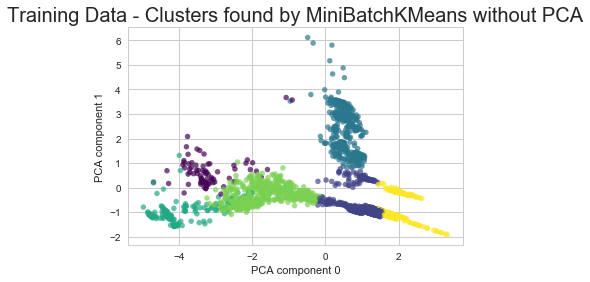

In [529]:
scaler = preprocessing.StandardScaler()
scaler.fit(df[features2])
pca = doPCA(scaler.transform(df[features2]), 2)
transformed_data = pca.transform(scaler.transform(df[features2]))
ind = np.argmax(transformed_data[ : ,1]) # outlier
transformed_data2 = np.delete(transformed_data, ind, 0) # to remove the ourlier

tr_data = scaler.transform(df[features2])
tr_data = np.delete(tr_data, ind, 0)


clusterer_pca = MiniBatchKMeans(n_clusters=6, random_state=10, n_init= 20)
cluster_labels2_pca = clusterer_pca.fit_predict(tr_data)

plt.scatter(transformed_data2[ : ,0],transformed_data2[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels2_pca, cmap= 'viridis')

plt.title('Training Data - Clusters found by MiniBatchKMeans without PCA', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

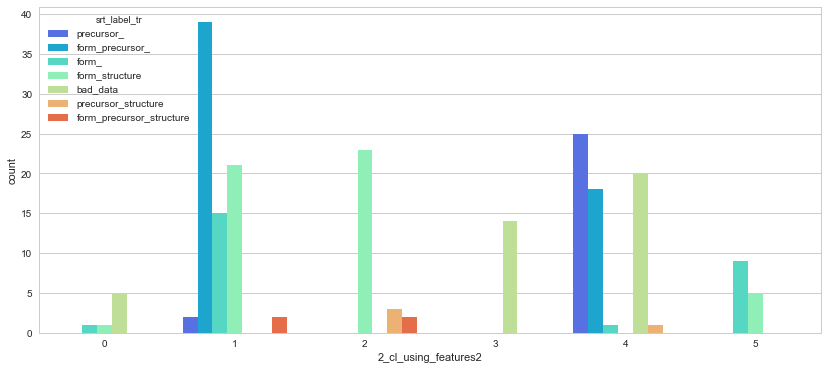

In [530]:
df_val = pd.read_csv('validation_set_20.csv')
transformed_data_val = pca.transform(scaler.transform(df_val[features2]))
cluster_labels_val = clusterer_pca.predict(scaler.transform(df_val[features2]))
df_val['2_cl_using_features2'] = cluster_labels_val 

fig, axes = plt.subplots(figsize=(14,6))
sns.countplot(data=df_val, hue='srt_label_tr',x = '2_cl_using_features2',palette='rainbow')

The Bad Data is not separated. **Analytical features** with PCA work better than without PCA.

<a id= analytical2.3></a>

## 2.3 Birch Clustering With PCA

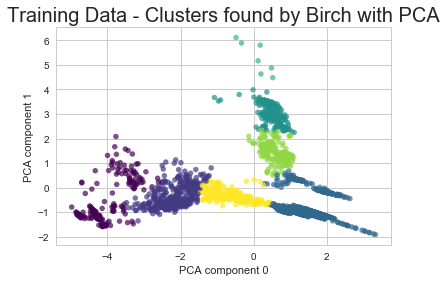

In [580]:
scaler = preprocessing.StandardScaler()
scaler.fit(df[features2])
pca = doPCA(scaler.transform(df[features2]), 2)
transformed_data = pca.transform(scaler.transform(df[features2]))
ind = np.argmax(transformed_data[ : ,1]) # outlier
transformed_data2 = np.delete(transformed_data, ind, 0) # to remove the ourlier

clusterer_pca = Birch(n_clusters=7)
cluster_labels2_pca = clusterer_pca.fit_predict(transformed_data2)

plt.scatter(transformed_data2[ : ,0],transformed_data2[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels2_pca, cmap= 'viridis')

plt.title('Training Data - Clusters found by Birch with PCA', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

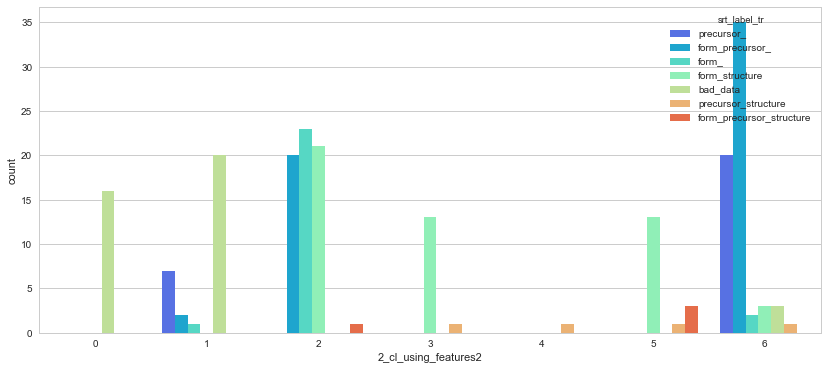

In [581]:
df_val = pd.read_csv('validation_set_20.csv')
transformed_data_val = pca.transform(scaler.transform(df_val[features2]))
cluster_labels_val = clusterer_pca.predict(transformed_data_val)
df_val['2_cl_using_features2'] = cluster_labels_val 

fig, axes = plt.subplots(figsize=(14,6))
sns.countplot(data=df_val, hue='srt_label_tr',x = '2_cl_using_features2',palette='rainbow')

In [582]:
df_val.loc[(df_val["2_cl_using_features2"]== 0) | (df_val["2_cl_using_features2"]== 1), "bad_data"] = 1
df_val.loc[df_val["bad_data"]!= 1, "bad_data"] = 0
accuracy_score(df_val['bad_data_tr'], df_val['bad_data'])

0.9371980676328503

In [583]:
df_val.loc[(df_val["2_cl_using_features2"]== 6), "precursor"] = 1
df_val.loc[df_val["precursor"]!= 1, "precursor"] = 0
accuracy_score(df_val['precursor_tr'], df_val['precursor'])

0.7874396135265701

In [584]:
df_val.loc[(df_val["2_cl_using_features2"]== 2) | (df_val["2_cl_using_features2"]== 3) |
           (df_val["2_cl_using_features2"]== 5) | (df_val["2_cl_using_features2"]== 6), "form"] = 1
df_val.loc[df_val["form"]!= 1, "form"] = 0
accuracy_score(df_val['form_tr'], df_val['form'])

0.85990338164251212

In [585]:
df_val.loc[(df_val["2_cl_using_features2"]== 4) | (df_val["2_cl_using_features2"]== 3) |
           (df_val["2_cl_using_features2"]== 5), "structure"] = 1
df_val.loc[df_val["structure"]!= 1, "structure"] = 0
accuracy_score(df_val['structure_tr'], df_val['structure'])

0.87439613526570048

<a id=analytical2.4></a>

## 2.4 Birch Clustering Without PCA

works not very well - Bad Data and Precursor is not separated.

<a id=analytical2.5></a>

## 2.5 Separating clusters by gap

KMean uses least square error for optimiszatin, thus the clusters have roundly "circle" shape. There are some other clustering methods in scikit-learn that can do it (for example, DBSCAN clustering), but all of these methods need whole traning set for retraining.

**Demo why we can use it**: 

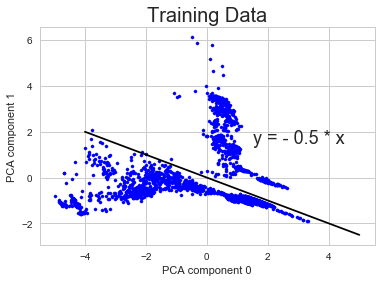

In [600]:
scaler = preprocessing.StandardScaler()
scaler.fit(df[features2])
pca = doPCA(scaler.transform(df[features2]), 2)
transformed_data = pca.transform(scaler.transform(df[features2]))
ind = np.argmax(transformed_data[ : ,1]) # outlier
transformed_data2 = np.delete(transformed_data, ind, 0) # to remove the ourlier
plt.scatter(transformed_data2[ : ,0],transformed_data2[ : ,1], color='b', alpha=1, s = 10)

plt.plot([-4, 5], [2,-2.5], 'k-') # y = 0.5 * x
plt.text(1.5, 1.5, 'y = - 0.5 * x', fontsize=18)
plt.title('Training Data', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

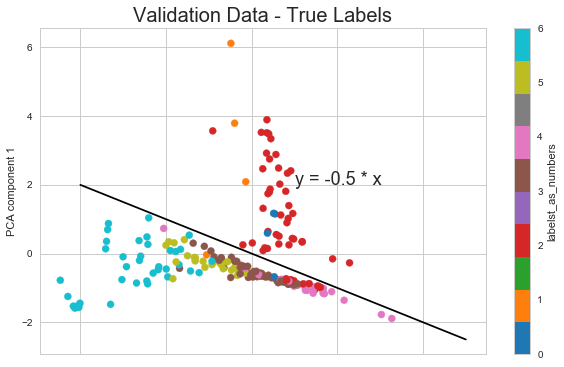

In [601]:
df_val = pd.read_csv('validation_set_20.csv')
transformed_data_val = pca.transform(scaler.transform(df_val[features2]))

labels_dict = {'form_precursor_structure': 0, 'precursor_structure': 1, 'form_structure': 2, 
               'form_precursor_': 3, 'form_': 4, 'precursor_': 5, 'bad_data': 6}
labelst_as_numbers = []
for i in df_val['srt_label_tr']:
    labelst_as_numbers.append(labels_dict[i])
    
df_val['pc0'] = transformed_data_val[ : ,0]
df_val['pc1'] = transformed_data_val[ : ,1]
df_val['labelst_as_numbers'] = labelst_as_numbers
    
df_val.plot.scatter(x='pc0',y='pc1',c='labelst_as_numbers',cmap='tab10',s= 50, figsize=(10,6))
plt.title('Validation Data - True Labels', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')
plt.plot([-4, 5], [2,-2.5], 'k-') # y = 0.5 * x
plt.text(1, 2, 'y = -0.5 * x', fontsize=18)

**almost all form_structure (red points) are above the line**

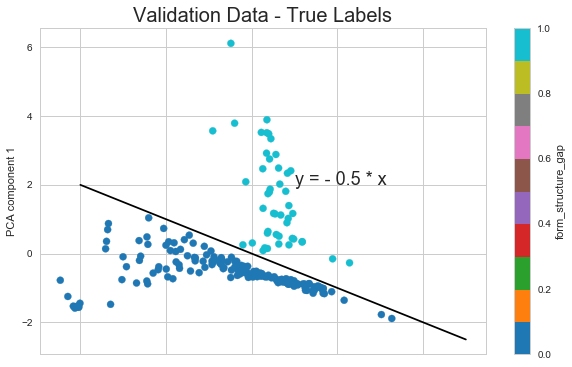

In [603]:
# Let's try to use this fact to create "form_structure_gap" label:

labels = []
for line in transformed_data_val:
    if line[1]> -0.5 * line[0]:
        labels.append(1)
    else:
        labels.append(0)
df_val['form_structure_gap'] = labels

df_val.plot.scatter(x='pc0',y='pc1',c='form_structure_gap',cmap='tab10',s= 50, figsize=(10,6))
plt.title('Validation Data - True Labels', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')
plt.plot([-4, 5], [2,-2.5], 'k-') # y = 0.5 * x
plt.text(1, 2, 'y = - 0.5 * x', fontsize=18)

In [604]:
df_val.loc[(df_val['srt_label_tr']== 'form_structure'), 'form_structure_tr'] = 1
df_val.loc[df_val["form_structure_tr"]!= 1, "form_structure_tr"] = 0

accuracy_score(df_val['form_structure_tr'], df_val['form_structure_gap'])

0.92270531400966183

**DBSCAN** could work in this case, but if has not partial_fit()

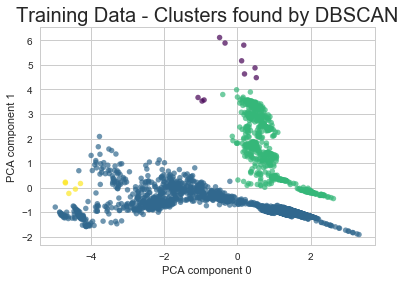

In [605]:
scaler = preprocessing.StandardScaler()
scaler.fit(df[features2])
pca = doPCA(scaler.transform(df[features2]), 2)
transformed_data = pca.transform(scaler.transform(df[features2]))
ind = np.argmax(transformed_data[ : ,1]) # outlier
transformed_data2 = np.delete(transformed_data, ind, 0) # to remove the ourlier

clusterer_pca = DBSCAN(eps=0.45)
cluster_labels2_pca = clusterer_pca.fit_predict(transformed_data2)

plt.scatter(transformed_data2[ : ,0],transformed_data2[ : ,1], s=30, lw=0, alpha=0.7,c=cluster_labels2_pca, cmap= 'viridis')

plt.title('Training Data - Clusters found by DBSCAN', fontsize=20)
plt.xlabel('PCA component 0')
plt.ylabel('PCA component 1')

<a id=q></a>

# Using Whole q Array

In [322]:
# this dataframe has whole q array as features
df2 = pd.read_pickle('df_for_clustering2.pkl')
df2.head(3)

,name,0,1,2,3,4,5,6,7,8,...,550,551,552,553,554,555,556,557,558,559
0,set_1_R1_1479582658,1.143534,0.497115,0.000000,0.473436,0.487803,0.906999,1.823430,1.289826,1.694177,...,2.251870,2.112009,2.084345,2.232733,2.299173,2.220341,2.055935,2.028783,2.046827,2.168071
1,set_1_R1_1479582669,0.000000,1.135393,1.251626,0.702255,0.592320,0.419255,1.134044,1.444593,1.232273,...,1.831821,2.005809,1.915149,1.888664,1.899058,1.803673,1.824841,1.802742,1.857838,1.863579
2,set_1_R1_1479582681,0.021854,0.157678,0.295437,0.000000,0.678777,0.898697,0.880770,1.121462,1.715802,...,1.793492,1.713437,1.781256,1.888325,1.836691,1.850607,1.762937,1.877357,1.942171,1.954817


In [323]:
features_q = df2.columns[1: ]

In [324]:
scaler = preprocessing.StandardScaler()
scaler.fit(df2[features_q])
scaled_q = scaler.transform(df2[features_q])

It is not reasonable to use PCA here, thus let's try to use others methods to select the number of clusters

### Selecting the number of clusters

For n_clusters = 2 The average silhouette_score is : 0.644505975189
For n_clusters = 3 The average silhouette_score is : 0.521911787743
For n_clusters = 4 The average silhouette_score is : 0.470841043971
For n_clusters = 5 The average silhouette_score is : 0.446305128215
For n_clusters = 6 The average silhouette_score is : 0.46346523046
For n_clusters = 7 The average silhouette_score is : 0.480227014974
For n_clusters = 8 The average silhouette_score is : 0.480968819328
For n_clusters = 9 The average silhouette_score is : 0.441495650521


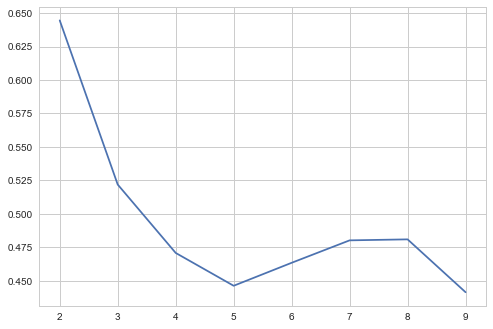

In [330]:
sa = []
for n_clusters in range(2,10):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(scaled_q)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(scaled_q, cluster_labels)
    sa.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

numb_cl = list(range(2,10))
plt.plot(numb_cl, sa)

For n_clusters = 2 The calinski_harabaz_score is : 1113.39604843
For n_clusters = 3 The calinski_harabaz_score is : 1114.06311843
For n_clusters = 4 The calinski_harabaz_score is : 1111.12488412
For n_clusters = 5 The calinski_harabaz_score is : 1148.04748513
For n_clusters = 6 The calinski_harabaz_score is : 1101.88920507
For n_clusters = 7 The calinski_harabaz_score is : 960.692311302
For n_clusters = 8 The calinski_harabaz_score is : 1146.97578117
For n_clusters = 9 The calinski_harabaz_score is : 1116.23058602


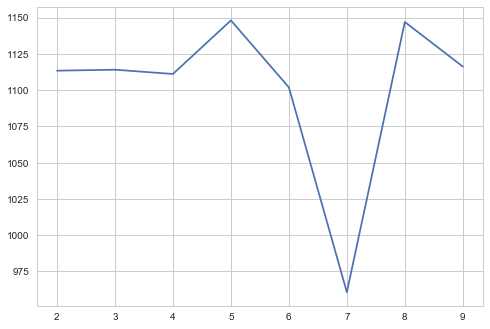

In [331]:
ch = []
for n_clusters in range(2,10):
    clusterer =  MiniBatchKMeans(n_clusters=5, n_init = 15)
    cluster_labels = clusterer.fit_predict(scaled_q)

    calinski_harabaz_sc = metrics.calinski_harabaz_score(scaled_q, cluster_labels)
    ch.append(calinski_harabaz_sc)
    print("For n_clusters =", n_clusters,
          "The calinski_harabaz_score is :", calinski_harabaz_sc)

numb_cl = list(range(2,10))
plt.plot(numb_cl, ch)

Let's try 2, 5, 8

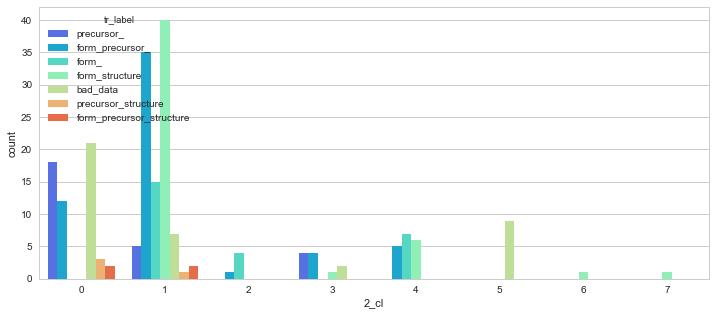

In [336]:
df2_val = pd.read_csv('validation_set_q.csv')

clusterer =  MiniBatchKMeans(n_clusters=8)
clusterer.fit(scaled_q)

transformed_data_val = scaler.transform(df2_val[features_q])

cluster_labels_val = clusterer.predict(transformed_data_val)
df2_val['2_cl'] = cluster_labels_val 

fig, axes = plt.subplots(figsize=(12,5))
sns.countplot(data=df2_val, hue='tr_label',x = '2_cl',palette='rainbow')

The result is not very useful :(

<a id=results></a>

# Unsupervised Learinig Results

### using bins

|               | accuracy of PAWS labeling |MiniBatchKMeans Using PCA, 5 clusters |Birch Using PCA, 7 clusters
| ------------- | ------------- |----------------
| bad_data  | 0.78  | 0.946 | 0.937
| precursor  | 0.55  | <span style="color:red"> **0.816**</span> | 0.816
| form | 0.91 | -- | 0.79
| structure | 0.85 | 0.874 | 0.880


### using analytical features

|               | accuracy of PAWS labeling |MiniBatchKMeans Using PCA, 6 clusters | Birch Using PCA 7 clusters
| ------------- | ------------- |----------------
| bad_data  | 0.78  | <span style="color:red"> **0.942**</span> | 0.937
| precursor  | 0.55  |  0.792 | 0.787
| form | 0.91 |<span style="color:red"> **0.859**</span> | 0.859
| structure | 0.85 | <span style="color:red"> **0.918**</span>  | 0.874

1. Bin strength with and without PCA give us almost the same result. 

2. Analytical features with PCAC work better than without PCA.

3. We can try to use "gap separation" to separate "form_structure" data. We got 92% accuracy for validatin set. But we need to use whole dataset for traning or do not do retraing of model for this label.

4. Using of whole q array as features is not usefull at this point. It is possible, that we can get a good result using whole q array wiht neural network, but we need to have more data (I think, at least 100 000 samples).

5. Using bins as features works better for "precursor," but analytical features works better for "structure."

**Feature work:**
    * we can try to use more bins (we had 12)
    * find some feture to separate precursor and form_precursor